# Разработка A/B-тестирования и анализ результатов


### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from math import ceil

In [3]:
display(sessions_history.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными


In [4]:
# Подсчитываем количество уникальных сессий для каждого пользователя
user_session_count = sessions_history.groupby('user_id')['session_id'].nunique()
# Находим пользователя с наибольшим количеством сессий
max_sessions_user = user_session_count.idxmax()
# Выводим все данные из таблицы для выбранного пользователя
user_data = sessions_history[sessions_history['user_id'] == max_sessions_user]
display(user_data)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### 1.3. Анализ числа регистраций


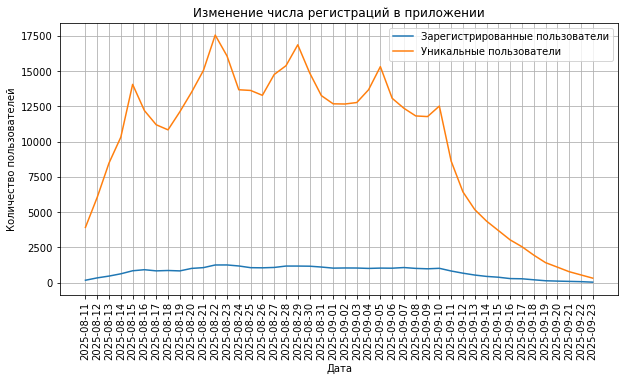

In [5]:
daily_unique_users = sessions_history.groupby(['session_date', 'registration_flag'])['user_id'].nunique().unstack(fill_value=0)

# Разделяем данные на зарегистрированных и уникальных пользователей
unique_users_registered = daily_unique_users[1]
unique_users_unregistered = daily_unique_users[0] + daily_unique_users[1]


# Визуализация результатов
plt.figure(figsize=(10, 5))
plt.plot(unique_users_registered.index, unique_users_registered, label='Зарегистрированные пользователи')
plt.plot(unique_users_unregistered.index, unique_users_unregistered, label='Уникальные пользователи')
plt.title('Изменение числа регистраций в приложении')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

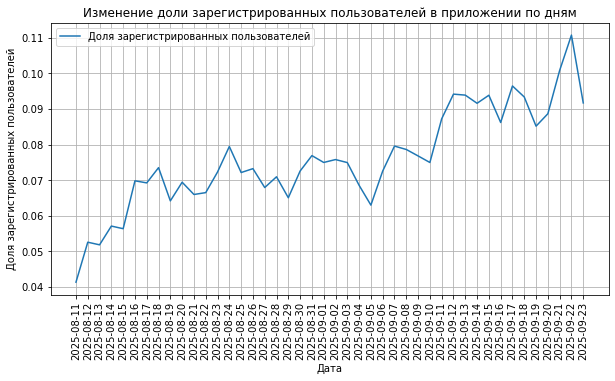

In [6]:
# Считаем общее количество уникальных пользователей по дням
total_unique_users = unique_users_registered + unique_users_unregistered

# Рассчитываем долю зарегистрированных пользователей
registered_users_share = unique_users_registered / total_unique_users

# Визуализация результатов
plt.figure(figsize=(10, 5))
plt.plot(registered_users_share.index, registered_users_share, label='Доля зарегистрированных пользователей')
plt.title('Изменение доли зарегистрированных пользователей в приложении по дням')
plt.xlabel('Дата')
plt.ylabel('Доля зарегистрированных пользователей')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

#### 1.4. Анализ числа просмотренных страниц


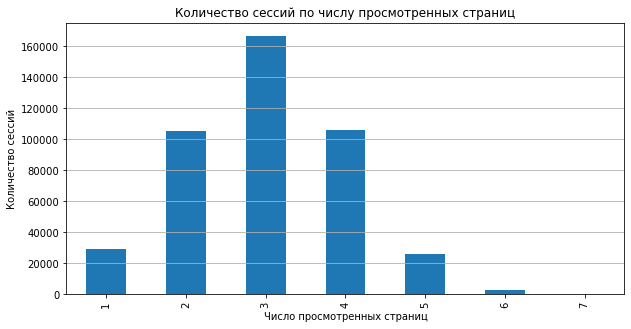

In [7]:
# Группируем данные по количеству просмотренных страниц и считаем количество сессий для каждого значения
page_views = sessions_history.groupby('page_counter').size()

# Визуализация результатов
plt.figure(figsize=(10, 5))
page_views.plot(kind='bar')
plt.title('Количество сессий по числу просмотренных страниц')
plt.xlabel('Число просмотренных страниц')
plt.ylabel('Количество сессий')
plt.grid(axis='y')
plt.show()

#### 1.5. Доля пользователей, просмотревших более четырёх страниц


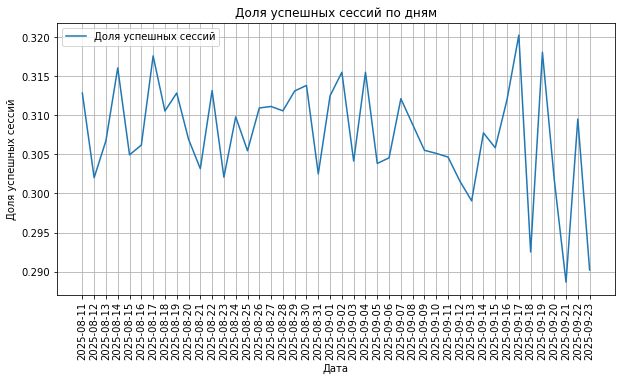

In [8]:
# Создаём дополнительный столбец good_session
sessions_history['good_session'] = sessions_history['page_counter'].apply(lambda x: 1 if x >= 4 else 0)

# Группируем данные по дням и вычисляем среднее значение доли успешных сессий
daily_good_sessions = sessions_history.groupby('session_date').agg(
    total_sessions=('session_id', 'count'),
    successful_sessions=('good_session', 'sum')
)
daily_good_sessions['success_rate'] = daily_good_sessions['successful_sessions'] / daily_good_sessions['total_sessions']

# Визуализация результатов
plt.figure(figsize=(10, 5))
plt.plot(daily_good_sessions.index, daily_good_sessions['success_rate'], label='Доля успешных сессий')
plt.title('Доля успешных сессий по дням')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

Промежуточный вывод:

Получены данные sessions_project_history.csv — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23.  Рассчитано число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Построены линейные графики доли зарегистрированных пользователей и уникальных пользователей в приложении по дням. Доля зарегистрированных пользователей значительно меньше, чем незарегистрированных.
        
Определено число просмотренных страниц в приложении. По графику видно , что в основном смотрят по 3 страницы за одну сессию. Выборочное среднее значение метрики распределение нормальное.

Определена доля успешных сессий (4 и боллее просмотров за одну сессию), она составляет около 0,3 от всех сессий.

### 2. Подготовка к тесту


#### 2.1 Формулировка нулевой и альтернативной гипотез



Сформулируйте нулевую и альтернативную гипотезы:

Нулевая гипотеза (H0): новый алгоритм рекомендаций не приводит к значимому изменению среднего значения доли успешных сессий от всех сессий по сравнению с текущим алгоритмом.

Альтернативная гипотеза (H1): новый алгоритм рекомендаций приводит к увеличению среднего значения доли успешных сессий от всех сессий по сравнению с текущим алгоритмом.

#### 2.2. Расчёт размера выборки


In [9]:


# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
p = 0.3 # Базовый уровень доли
mde = 0.03 * p  # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p, p + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


#### 2.3. Расчёт длительности A/B-теста



In [10]:


# Среднее количество пользователей приложения в день по историческим данным
user_session_count = sessions_history.groupby('session_date')['user_id'].nunique()
avg_daily_users = user_session_count.mean()


# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size * 2 / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.363636363636 пользователей в день составит 9 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей



In [11]:
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

In [12]:
sessions_test_part.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3130 entries, 0 to 3129
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            3130 non-null   object
 1   session_id         3130 non-null   object
 2   session_date       3130 non-null   object
 3   session_start_ts   3130 non-null   object
 4   install_date       3130 non-null   object
 5   session_number     3130 non-null   int64 
 6   registration_flag  3130 non-null   int64 
 7   page_counter       3130 non-null   int64 
 8   region             3130 non-null   object
 9   device             3130 non-null   object
 10  test_group         3130 non-null   object
dtypes: int64(3), object(8)
memory usage: 269.1+ KB


In [13]:
display(sessions_test_part.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [14]:
sessions_test_part['test_group'].unique() 

array(['B', 'A'], dtype=object)

In [15]:
# Группируем данные по тестовой группе и считаем количество уникальных пользователей
unique_users_by_group = sessions_test_part.groupby('test_group')['user_id'].nunique()

# Получаем количество пользователей в группах A и B
group_A_count = unique_users_by_group['A']
group_B_count = unique_users_by_group['B']


print("Количество уникальных зарегистрированных пользователей по дням:")
print(group_A_count)
print("\nКоличество уникальных незарегистрированных пользователей по дням:")
print(group_B_count)

Количество уникальных зарегистрированных пользователей по дням:
1477

Количество уникальных незарегистрированных пользователей по дням:
1466


Процентная разница в количестве пользователей между группами A и B: 0.74%


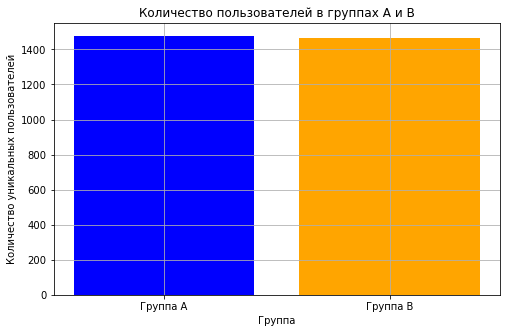

In [16]:
# Рассчитываем процентную разницу
percentage_diff = 100 * abs(group_A_count - group_B_count) / group_A_count

print(f"Процентная разница в количестве пользователей между группами A и B: {percentage_diff:.2f}%")

# Визуализация результатов
plt.figure(figsize=(8, 5))
plt.bar(['Группа A', 'Группа B'], [group_A_count, group_B_count], color=['blue', 'orange'])
plt.title('Количество пользователей в группах A и B')
plt.xlabel('Группа')
plt.ylabel('Количество уникальных пользователей')
plt.grid()
plt.show()

#### 3.2. Проверка пересечений пользователей


In [17]:
# Разделение данных на группы A и B
group_A = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id']
group_B = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id']

# Находим пересечение пользователей в группах A и B
common_users = set(group_A).intersection(set(group_B))

# Выводим количество общих пользователей
print(f"Количество пользователей, которые встречаются одновременно в группах A и B: {len(common_users)}")

Количество пользователей, которые встречаются одновременно в группах A и B: 0


#### 3.3. Равномерность разделения пользователей по устройствам


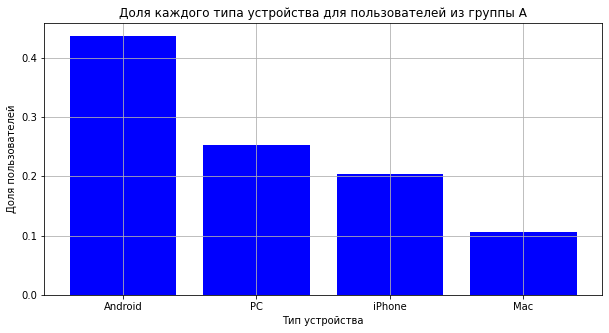

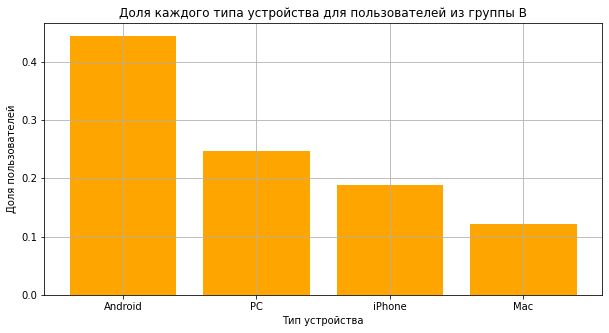

In [18]:
# Разделение данных на группы A и B
group_A = sessions_test_part[sessions_test_part['test_group'] == 'A']
group_B = sessions_test_part[sessions_test_part['test_group'] == 'B']

# Группировка данных по типу устройства для каждой группы
device_types_A = group_A['device'].value_counts(normalize=True)
device_types_B = group_B['device'].value_counts(normalize=True)

# Визуализация результатов для группы A
plt.figure(figsize=(10, 5))
plt.bar(device_types_A.index, device_types_A, color='blue')
plt.title('Доля каждого типа устройства для пользователей из группы A')
plt.xlabel('Тип устройства')
plt.ylabel('Доля пользователей')
plt.grid()
plt.show()

# Визуализация результатов для группы B
plt.figure(figsize=(10, 5))
plt.bar(device_types_B.index, device_types_B, color='orange')
plt.title('Доля каждого типа устройства для пользователей из группы B')
plt.xlabel('Тип устройства')
plt.ylabel('Доля пользователей')
plt.grid()
plt.show()
 

#### 3.4. Равномерность распределения пользователей по регионам


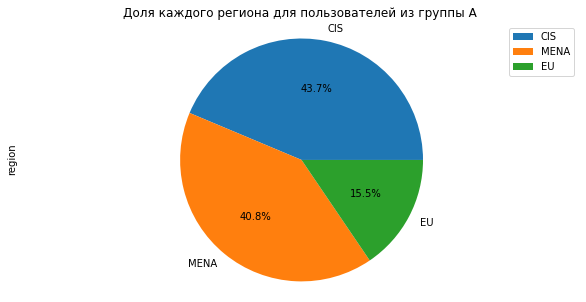

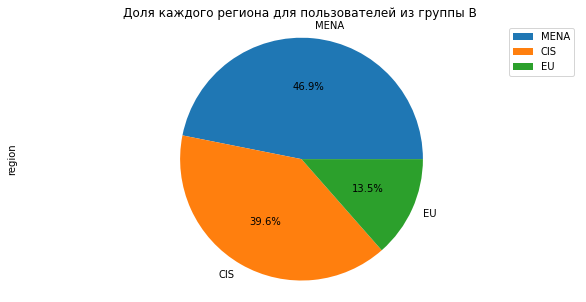

In [19]:
# Группировка данных по регионам для каждой группы
regions_A = group_A['region'].value_counts(normalize=True)
regions_B = group_B['region'].value_counts(normalize=True)

# Визуализация результатов для группы A
plt.figure(figsize=(10, 5))
regions_A.plot(kind='pie', autopct='%.1f%%')
plt.title('Доля каждого региона для пользователей из группы A')
plt.axis('equal')  # Чтобы круг был идеально круглым
plt.legend(loc='best')
plt.show()

# Визуализация результатов для группы B
plt.figure(figsize=(10, 5))
regions_B.plot(kind='pie', autopct='%.1f%%')
plt.title('Доля каждого региона для пользователей из группы B')
plt.axis('equal')  # Чтобы круг был идеально круглым
plt.legend(loc='best')
plt.show()

#### 3.5. Вывод после проверки A/B-теста



На основе проведённого анализа A/B-теста делаем вывод, что:

- Не обнаружено различие в количестве пользователей в двух группах(различие незначительное 0,74%).

- Выборки являются независимыми. Пересечение пользователей из тестовой и контрольной групп не обнаружено.

- Сохраняется равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

заключение: корректно проходит A/B-тест.

### 4. Проверка результатов A/B-теста



#### 4.1. Получение результатов теста и подсчёт основной метрики



In [20]:
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

In [21]:
# Создаём дополнительный столбец good_session
sessions_test['good_session'] = sessions_test['page_counter'].apply(lambda x: 1 if x >= 4 else 0)

In [22]:
display(sessions_test.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


#### 4.2. Проверка корректности результатов теста



In [23]:
# Группируем данные по дате и тестовой группе, считаем количество уникальных сессий
sessions_by_date_and_group = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique()
# Разделяем данные на группы A и B
group_A_sessions = sessions_by_date_and_group.xs('A', level='test_group')
group_B_sessions = sessions_by_date_and_group.xs('B', level='test_group')

# Проводим t-тест для сравнения средних
t_stat, p_value = ttest_ind(group_A_sessions, group_B_sessions)

print(f"Значение p-value: {p_value}")

# Интерпретация результата
if p_value > 0.05:
    print("Различия в количестве уникальных дневных сессий между группами A и B не являются статистически значимыми.")
else:
    print("Различия в количестве уникальных дневных сессий между группами A и B являются статистически значимыми.")
 

Значение p-value: 0.938219304859116
Различия в количестве уникальных дневных сессий между группами A и B не являются статистически значимыми.


#### 4.3. Сравнение доли успешных сессий



In [24]:
# Группируем данные по тестовой группе 
grouped = sessions_test.groupby('test_group')['good_session'].mean()

# Получаем долю успешных сессий для групп A и B
group_A_success_rate = grouped['A']
group_B_success_rate = grouped['B']

# Рассчитываем разницу в доле успешных сессий между группами
difference = group_A_success_rate - group_B_success_rate

print(f"Доля успешных сессий в группе A: {group_A_success_rate:.2%}")
print(f"Доля успешных сессий в группе B: {group_B_success_rate:.2%}")
print(f"Разница в доле успешных сессий: {difference:.2%}")

Доля успешных сессий в группе A: 30.77%
Доля успешных сессий в группе B: 31.83%
Разница в доле успешных сессий: -1.06%


#### 4.4. Насколько статистически значимо изменение ключевой метрики



In [25]:
# Группируем данные по тестовой группе и считаем количество успешных сессий
grouped = sessions_test.groupby('test_group')['good_session']

# Разделяем данные на группы A и B
group_A_success = grouped.get_group('A')
group_B_success = grouped.get_group('B')

# Проводим t-тест для сравнения средних
t_stat, p_value = ttest_ind(group_A_success, group_B_success)

print(f"Значение p-value: {p_value}")

# Интерпретация результата
if p_value > 0.05:
    print("Различия в доле успешных сессий между группами A и B не являются статистически значимыми.")
else:
    print("Различия в доле успешных сессий между группами A и B являются статистически значимыми.")
 

Значение p-value: 0.0003148608995858183
Различия в доле успешных сессий между группами A и B являются статистически значимыми.


#### 4.5. Вывод по результатам A/B-эксперимента



На основе проведённого анализа результатов теста сделали выводы для команды разработки приложения:

- Характеристики проведённого эксперимента - Z-тест пропорций — это статистический тест, который позволяет определить, существует ли значимая разница между долями в двух независимых выборках. Размер выборки для каждой группы: 41040 чел, и длительность эксперимента - 9 дней.

- внедрение нового алгоритма рекомендаций привело к увеличению количества успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной.

- для оценки статистической значимости выявленного эффекта значение p-value  - 0.0003148608995858183, что  < (alpha = 0.05 Уровень значимости). Значит верим в истинность гипотезы H1.

- Посколько выборочные средние значения не равны и верна альтернативная гипотеза, основания полагать, что новый алгоритм приведет к статическому росту. 

Стоит внедрять нововведение в приложение.